In [96]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
from scipy.integrate import solve_ivp
from function_list import *
plt.rcParams['text.usetex'] = True

### Tutorial 2: Question 3
We seek to solve the following boundary value problem 
\begin{equation}
y''=-(y')^2-y+\ln x, \quad y(1)=0, \quad y(2)=\ln 2
\end{equation}
using the shooting method and the finite difference method.

Using the boundary conditions, we will set up the interval of integration

In [97]:
x = np.linspace(1, 2, 100)

#### The Shooting Method
The equation can be expressed as two first order equations
\begin{equation}
\begin{cases}
y'=u\\
u'=-u^2-y+\ln x
\end{cases}
\end{equation}

In [98]:
def f(x, y):
    return y[1], -y[1]**2 - y[0] + np.log(x)

We can determine an approximate interval $c\leq p\leq d$ such that
\begin{equation}
\begin{cases}
y(2)-\ln(2) < 0,\quad&p=c\\
y(2)-\ln(2) > 0,\quad&p=d
\end{cases}
\end{equation}

In [99]:
for i in np.linspace(0.5, 1.5, 10):
    yprime0 = i
    y0 = [0, yprime0]

    sol = solve_ivp(f, [1, 2], y0, t_eval=x)
    y = sol.y[0, :]

    if y[-1] - np.log(2) < 0:
        print('p={:.5f}, greater than'.format(i))
    elif y[-1] - np.log(2) > 0:
        print('p={:.5f}, less than'.format(i))

p=0.50000, greater than
p=0.61111, greater than
p=0.72222, greater than
p=0.83333, greater than
p=0.94444, greater than
p=1.05556, less than
p=1.16667, less than
p=1.27778, less than
p=1.38889, less than
p=1.50000, less than


We observe that $p$ lies in the approximate interval $0.5\leq p\leq 1.5$. We can now implement the bisection method to find $p$ such that 
\begin{equation}
|y_{n-1}-y_n|<\varepsilon
\end{equation}
where $\varepsilon$ is a set tolerance.

In [100]:
def shooting_method(p, x, tol=10**(-6)):
    pstart, pend = p
    n_iterations = 0

    while np.abs(pend - pstart) > tol:
        updated_p = (pend + pstart) / 2
        y0 = [0, updated_p]
        sol = solve_ivp(f, [1, 2], y0, t_eval=x)
        y = sol.y[0, :]

        if y[-1] - np.log(2) < 0:
            pstart = updated_p
        elif y[-1] - np.log(2) > 0:
            pend = updated_p

        diff = np.abs(pend - pstart)
        n_iterations += 1

    return [y, n_iterations]

We can now plot the solution obtained by the shooting method along with the exact solution 
\begin{equation}
y(x)=\ln(x)
\end{equation}

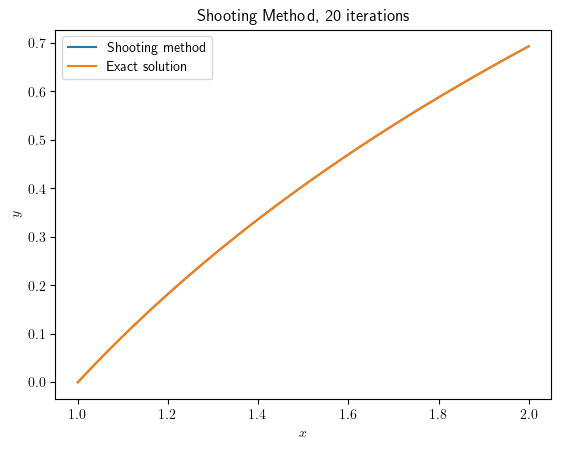

In [101]:
y, n_iterations = shooting_method([0.5, 1.5], x)
plt.plot(x, y, label='Shooting method')
plt.plot(x, np.log(x), label='Exact solution')
plt.title(r'Shooting Method, {} iterations'.format(n_iterations))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

#### Finite Differnce Method
Expressing the boundary value problem as
\begin{equation}
F(y)=
\begin{cases}
y''+(y')^2+y-\ln x \\
y(1) = 0 \\
y(2) - \ln 2 = 0
\end{cases}
\end{equation}

The Fréchet derivative is
\begin{equation}
F'(z)=
\begin{cases}
\left[\frac{d^2}{dx^2} + 2y'\frac{d}{dx} + 1\right] z \\
z(1) \\
z(2)
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F'z=-F$ is
\begin{align}
z''+2y'z' + z &= -\left[ y'' + (y')^2 + y - \ln x\right] \\
z(1) &= -y(1) \\
z(2) &= -\left[ y(2) - \ln 2 \right]
\end{align}

We now want to solve this system using finite differences. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N+1$ points and $N$ spacings between those points of width $h$.

In [102]:
a, b = [1, 2] # [start point, end point]
N = 100 # number of points
h = (b-a)/N # space width
x = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

Substituting the centred finite differences into the Newton-Kantorovich equation 
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} + 2\frac{y_{j+1}-y_{j-1}}{2h} \frac{z_{j+1}-z_{j-1}}{2h} + z_j &= - \left[\frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2+y_j - \ln x_j \right] \\
z_1 &= - y_1 \\
z_{N+1} &= -\left[y_{N+1} - \ln 2\right]
\end{align}

Factoring the left hand side in terms of $z$
\begin{align}
z_{j-1}\left[\frac{1}{h^2} - \frac{1}{h}\left(\frac{y_{j+1}-y_{j-1}}{2h}\right)\right] + z_j\left[-\frac{2}{h^2} + 1\right] + z_{j+1}\left[\frac{1}{h^2} + \frac{1}{h}\left(\frac{y_{j+1}-y_{j-1}}{2h}\right)\right] &= - \left[\frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2+y_j - \ln x_j \right] \\
z_1 &= - y_1 \\
z_{N+1} &= -\left[y_{N+1} - \ln 2\right]
\end{align}

We can now express $F^{\,\prime}$ as a Jacobian matrix

In [103]:
def finite_diff(y2, y1, h):
    return (y2-y1)/(2*h)

def jacobian_f(N, x, y, h):
    jacobian = np.zeros((N+1, N+1))
    
    jacobian[(0,0)] = 1
    jacobian[(N,N)] = 1
    
    diag_1, diag_2, diag_3 = [], -(2/h**2) + 1, []
    
    for i in range(1,N):
        diag_1.append((1/(h**2))-(1/h)*(finite_diff(y[i+1], y[i-1], h)))
        diag_3.append((1/(h**2))+(1/h)*(finite_diff(y[i+1], y[i-1], h)))
        
    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Similarly, we can express $-F$ as a vector to solve $F'z=-F$

In [104]:
def vec_f(N, x, y, h):
    A = np.zeros(N + 1)
    
    A[0] = -y[0]
    A[N] = -y[N] + np.log(2)

    for i in range(1, N):
        A[i] = -((y[i-1]-2*y[i]+y[i+1])/(h**2)) - finite_diff(y[i+1], y[i-1], h)**2 - y[i] + np.log(x[i])

    return A

We can now create a while loop to iteratively solve for $\vec{y}$ with corrections $\vec{z}$

In [105]:
def newton_kantorovich_method_f(N, x, y, h, tol=10**(-6)):
    n_iterations = 0
    A = vec_f(N, x, y, h)

    while norm(A) > tol and n_iterations < 100:
        jacobian = jacobian_f(N, x, y, h)
        z = solve(jacobian, A)
        y = y + z
        A = vec_f(N, x, y, h)
        n_iterations = n_iterations + 1

    return [y, n_iterations]

We can now test this using the values obtained from the shooting method as the ansatz for $y$ 

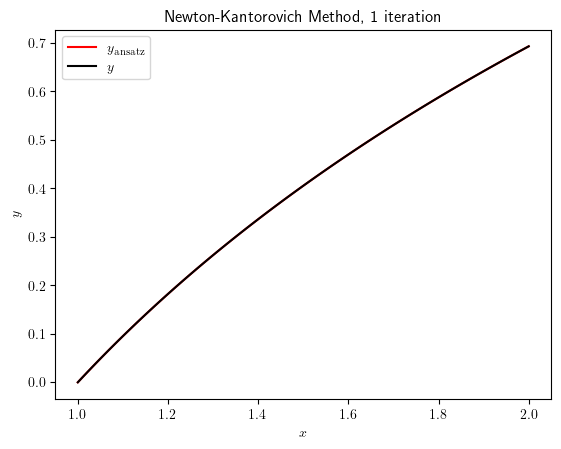

In [106]:
y_ansatz = shooting_method([0.5, 1.5], x)[0]
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h)
plot_f(x, y_ansatz, y, n_iterations, 'x', 'y')

We can test this using the ansatz
\begin{equation}
y(x) = \frac{1}{1+x^2}
\end{equation}

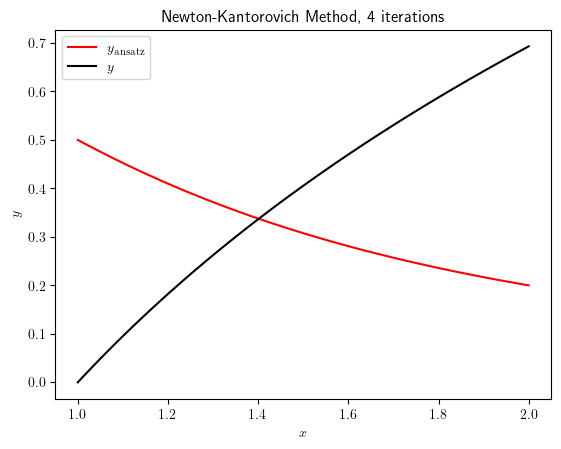

In [107]:
y_ansatz = 1/(1+x**2)
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h)
plot_f(x, y_ansatz, y, n_iterations, 'x', 'y')